In [22]:
import pandas as pd

data=pd.read_csv("18100205.csv")

data.head() 

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1
1,1981-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1
2,1981-01,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,40.6,NaN,NaN,NaN,1
3,1981-01,Atlantic Region,2016A00011,Total (house and land),"Index, 201612=100",347,units,0,v111955445,2.1,NaN,..,NaN,NaN,1
4,1981-01,Atlantic Region,2016A00011,House only,"Index, 201612=100",347,units,0,v111955446,2.2,NaN,..,NaN,NaN,1


In [23]:
data.dtypes

REF_DATE                      object
GEO                           object
DGUID                         object
New housing price indexes     object
UOM                           object
UOM_ID                         int64
SCALAR_FACTOR                 object
SCALAR_ID                      int64
VECTOR                        object
COORDINATE                   float64
VALUE                        float64
STATUS                        object
SYMBOL                       float64
TERMINATED                   float64
DECIMALS                       int64
dtype: object

In [24]:
data = data[['REF_DATE', 'GEO', 'New housing price indexes', 'VALUE']].rename(columns = {'New housing price indexes' : 'HPI'})

In [25]:
data.head()

,REF_DATE,GEO,HPI,VALUE
0,1981-01,Canada,Total (house and land),38.2
1,1981-01,Canada,House only,36.1
2,1981-01,Canada,Land only,40.6
3,1981-01,Atlantic Region,Total (house and land),NaN
4,1981-01,Atlantic Region,House only,NaN


In [26]:
filtered_data1 = data.loc[data.GEO == 'Canada']

In [27]:
filtered_data = filtered_data1.loc[filtered_data1.HPI == 'Total (house and land)']

In [28]:
print(filtered_data.isnull().sum())
filtered_data.head()

REF_DATE    0
GEO         0
HPI         0
VALUE       0
dtype: int64


,REF_DATE,GEO,HPI,VALUE
0,1981-01,Canada,Total (house and land),38.2
120,1981-02,Canada,Total (house and land),38.7
240,1981-03,Canada,Total (house and land),39.3
360,1981-04,Canada,Total (house and land),39.9
480,1981-05,Canada,Total (house and land),40.6


In [29]:
filtered_data2 = filtered_data[['REF_DATE', 'VALUE']]

filtered_data2.REF_DATE = pd.to_datetime(filtered_data2.REF_DATE)
filtered_data2.set_index('REF_DATE', inplace=True)

#filtered_data.index = pd.to_datetime(filtered_data.index, format='%Y-%m', errors='coerce').dropna()

filtered_data2.dtypes

filtered_data2.head()

C:\Users\prasa\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,VALUE
REF_DATE,
1981-01-01,38.2
1981-02-01,38.7
1981-03-01,39.3
1981-04-01,39.9
1981-05-01,40.6


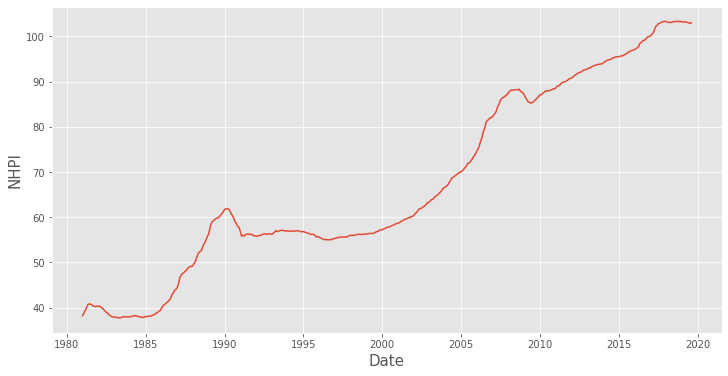

In [142]:
from datetime import date, timedelta
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
%matplotlib inline
style.use('ggplot')
register_matplotlib_converters()

plt.figure(figsize = (12,6))
plt.plot(filtered_data2["VALUE"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('NHPI',fontsize=15)
plt.show()

C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


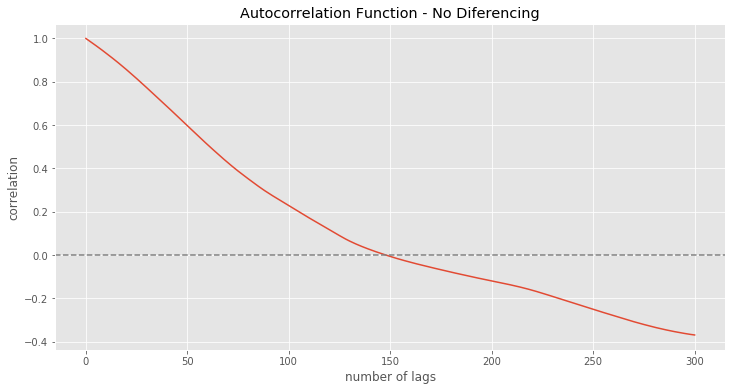

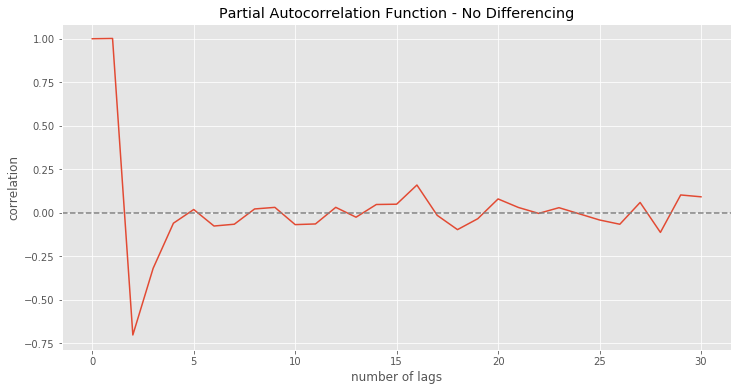

In [140]:
from statsmodels.tsa.stattools import acf, pacf

#filtered_data2.VALUE = str(filtered_data2.VALUE)
train_temp =  filtered_data2.iloc[:-30]
test = filtered_data2.tail(30)

#calling auto correlation function
lag_acf = acf(train_temp, nlags=300)
#Plot PACF:
plt.figure(figsize=(12, 6))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function - No Diferencing')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.show()


#calling partial auto correlation function
lag_pacf = pacf(train_temp, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(12, 6))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function - No Differencing')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.show()


In [139]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(filtered_data2['VALUE'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.372788
p-value: 0.914544
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [185]:
# First differenced model on actual data

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas import DataFrame

model_arima = ARIMA(train_temp, order=(5,1,5))
arima_fit = model_arima.fit(disp=0)

print(arima_fit.summary())


C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.VALUE   No. Observations:                  433
Model:                 ARIMA(5, 1, 5)   Log Likelihood                 114.748
Method:                       css-mle   S.D. of innovations              0.184
Date:                Mon, 25 Nov 2019   AIC                           -205.496
Time:                        20:22:15   BIC                           -156.647
Sample:                    02-01-1981   HQIC                          -186.212
                         - 02-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1489      0.018      8.275      0.000       0.114       0.184
ar.L1.D.VALUE     1.0201      0.762      1.339      0.181      -0.473       2.513
ar.L2.D.VALUE    -0.3561      1.159     

<Figure size 864x432 with 0 Axes>

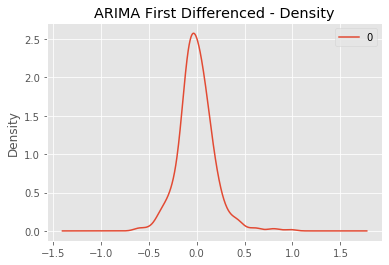

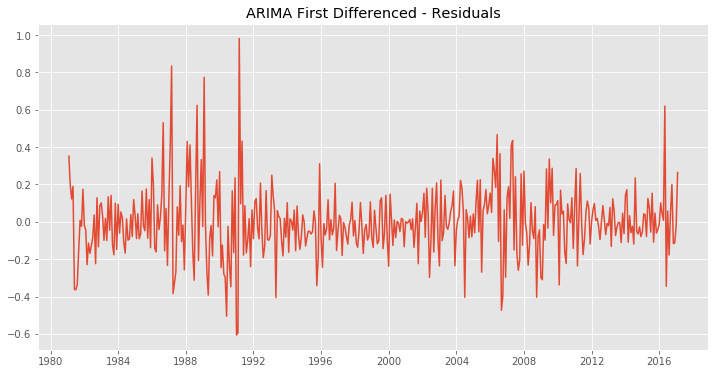

In [210]:
residuals = DataFrame(arima_fit.resid)

plt.figure(figsize = (12,6))
residuals.plot(kind='kde')
plt.title('ARIMA First Differenced - Density')
plt.show()

plt.figure(figsize = (12,6))
plt.plot(residuals)
plt.title('ARIMA First Differenced - Residuals')
plt.show()


In [187]:
print(residuals.describe())

                0
count  433.000000
mean    -0.003648
std      0.186214
min     -0.605887
25%     -0.101115
50%     -0.013811
75%      0.093644
max      0.981600


In [188]:
# Multi step forecast
forecast = arima_fit.forecast(len(test))
yhat = pd.DataFrame(forecast[0], index=test.index.copy())
#print(yhat)

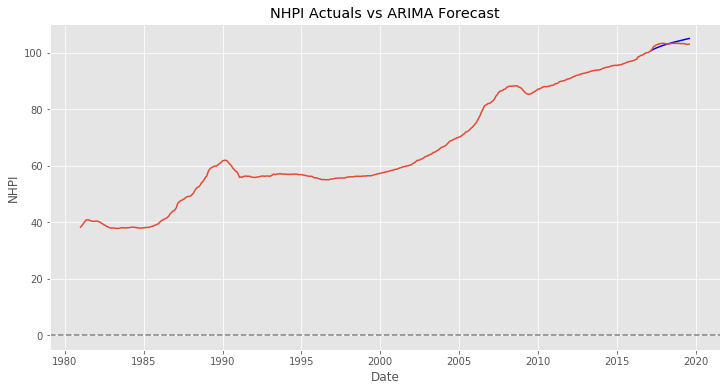

In [211]:
plt.figure(figsize=(12, 6))
plt.plot(yhat, 'b')
plt.plot(filtered_data2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('NHPI Actuals vs ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('NHPI')
plt.show()

In [190]:
error = mean_squared_error(test, yhat)
print(error)

1.0070831363100234


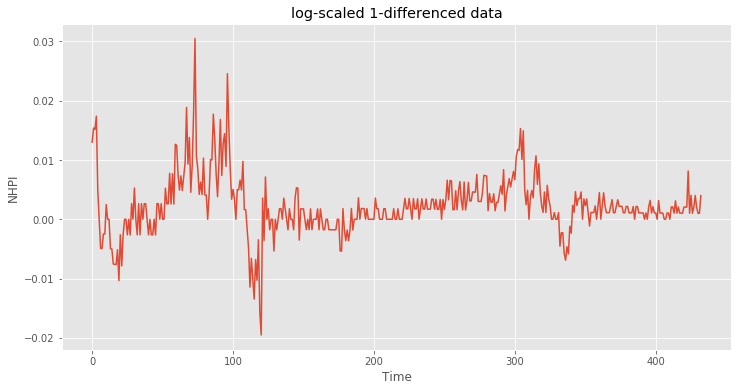

C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


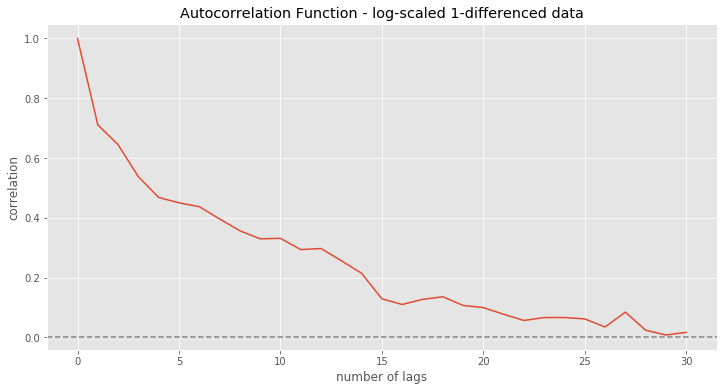

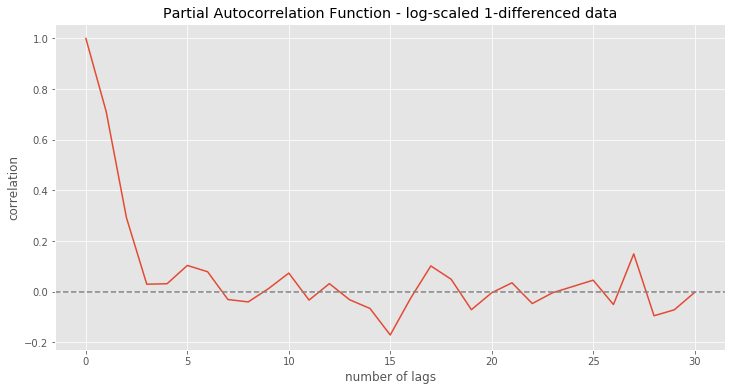

In [143]:
# LOG DIFFERENCED MODEL
import numpy as np

train_log1 =  np.log(train_temp)
train1 = train_log1.diff(periods=1).values[1:]

plt.figure(figsize = (12,6))
plt.plot(train1)
plt.title('log-scaled 1-differenced data')
plt.xlabel('Time')
plt.ylabel('NHPI')
plt.show()


#calling auto correlation function
lag_acf1 = acf(train1, nlags=30)
#Plot PACF:
plt.figure(figsize=(12, 6))
plt.plot(lag_acf1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function - log-scaled 1-differenced data')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.show()


#calling partial auto correlation function
lag_pacf1 = pacf(train1, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(12, 6))
plt.plot(lag_pacf1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function - log-scaled 1-differenced data')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.show()

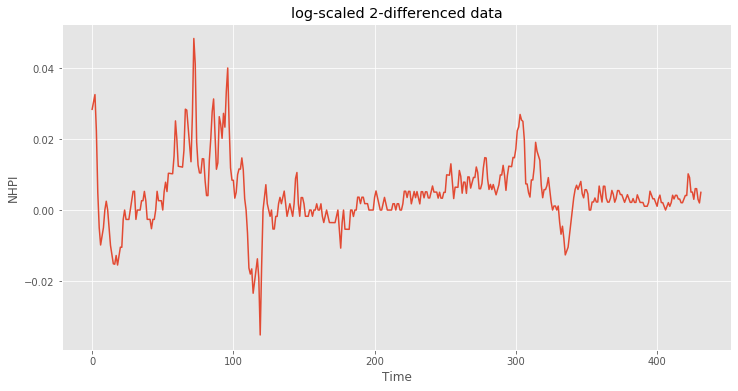

C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


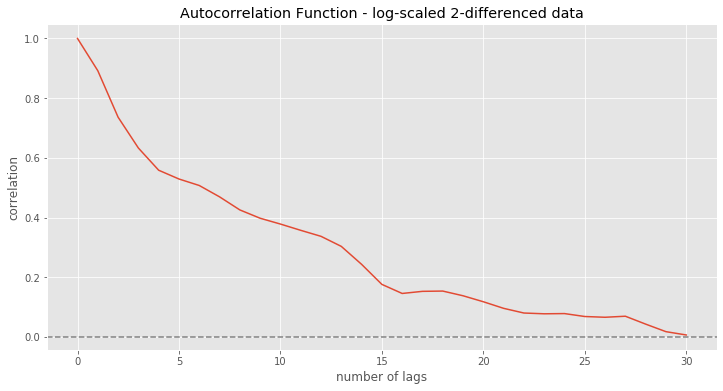

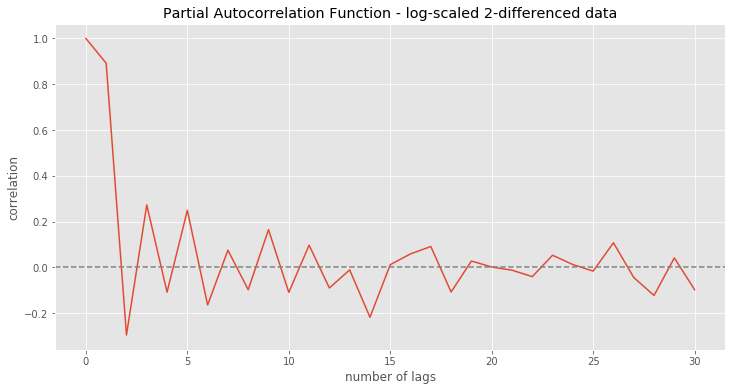

In [165]:
# 2 differenced data
train_log2 =  np.log(train_temp)
train2 = train_log2.diff(periods=2).values[2:]

plt.figure(figsize = (12,6))
plt.plot(train2)
plt.title('log-scaled 2-differenced data')
plt.xlabel('Time')
plt.ylabel('NHPI')
plt.show()


#calling auto correlation function
lag_acf2 = acf(train2, nlags=30)
#Plot PACF:
plt.figure(figsize=(12, 6))
plt.plot(lag_acf2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function - log-scaled 2-differenced data')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.show()


#calling partial auto correlation function
lag_pacf2 = pacf(train2, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(12, 6))
plt.plot(lag_pacf2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function - log-scaled 2-differenced data')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.show()

In [179]:
#first differenced model
model_arima1 = ARIMA(train_log1, order=(5,1,5))
arima_fit1 = model_arima1.fit(disp=0)

print(arima_fit1.summary())

C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\prasa\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.VALUE   No. Observations:                  433
Model:                 ARIMA(5, 1, 5)   Log Likelihood                1868.246
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 25 Nov 2019   AIC                          -3712.491
Time:                        20:21:29   BIC                          -3663.642
Sample:                    02-01-1981   HQIC                         -3693.208
                         - 02-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0023      0.000      9.835      0.000       0.002       0.003
ar.L1.D.VALUE     0.9554      0.154      6.218      0.000       0.654       1.257
ar.L2.D.VALUE    -0.0300      0.273     

<Figure size 864x432 with 0 Axes>

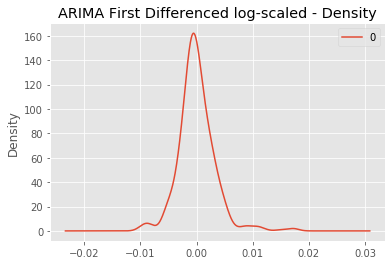

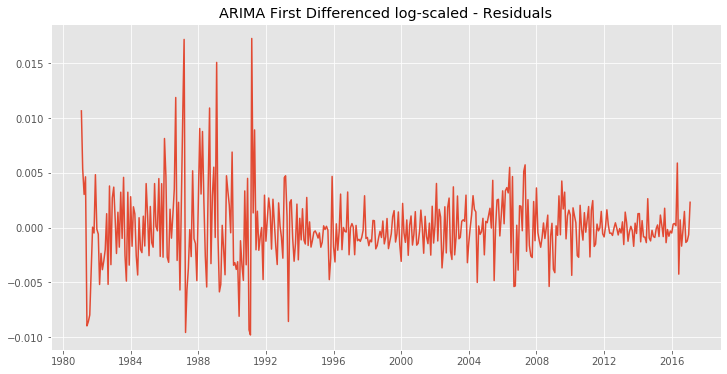

In [212]:
residuals1 = DataFrame(arima_fit1.resid)

plt.figure(figsize = (12,6))
residuals1.plot(kind='kde')
plt.title('ARIMA First Differenced log-scaled - Density')
plt.show()

plt.figure(figsize = (12,6))
plt.plot(residuals1)
plt.title('ARIMA First Differenced log-scaled - Residuals')
plt.show()

In [192]:
print(residuals1.describe())

                0
count  433.000000
mean     0.000011
std      0.003268
min     -0.009805
25%     -0.001638
50%     -0.000291
75%      0.001506
max      0.017287


In [213]:
# Multi step forecast
forecast1 = arima_fit1.forecast(len(test))
yhat1 = pd.DataFrame(forecast1[0], index=test.index.copy())
yhat1 = np.exp(yhat1)
#print(yhat1)
#print(train)

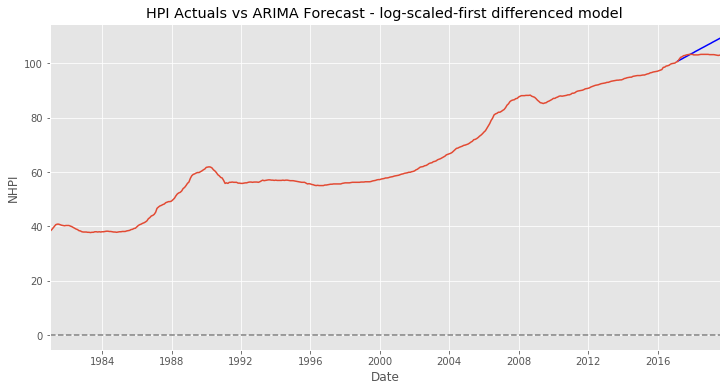

In [216]:
plt.figure(figsize=(12, 6))
plt.plot(yhat1, 'b')
plt.plot(filtered_data2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('HPI Actuals vs ARIMA Forecast - log-scaled-first differenced model')
plt.xlabel('Date')
plt.ylabel('NHPI')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

In [215]:
error = mean_squared_error(test, yhat1)
print(error)

9.124876337467875
